In [3]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
%matplotlib inline

Using TensorFlow backend.


## 1. Data Preparation

In [4]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

In [5]:
series1.head()

timestamp
2019-01-13 00:00:00    31.090000
2019-01-13 00:05:00    31.106000
2019-01-13 00:10:00    31.129999
2019-01-13 00:15:00    31.146000
2019-01-13 00:20:00    31.170000
Name: CWRT_syth, dtype: float64

### 1.1 Remove the days with missing value

In [8]:
series1 = series1.drop(index=series1['2019-01-21'].index)
series1 = series1.drop(index=series1['2019-01-23'].index)
series1 = series1.drop(index=series1['2019-02-17'].index)
series1 = series1.drop(index=series1['2019-03-06'].index)
series1 = series1.drop(index=series1['2019-03-10'].index)
series1 = series1.drop(index=series1['2019-03-15'].index)

## 2. Time-based sequence extraction

In [9]:
from datetime import time

window_size = 12*6
step_size = 6
seqs = list()
seq_timestamps = list()
for i in range(0, series1.shape[0], step_size):
#     if (v.time()>=time(9, 0)) and (v.time()<=time(9, 15)):
    if i+window_size<series1.shape[0]:
        seq = series1[i:i+window_size].to_list()
        if (len(seq)==window_size):
            seqs.append(seq)
            seq_timestamps.append(series1.index[i])
X = np.array(seqs)
y = np.array(seqs)

## 2. Clustering the temporal windows

### One step missing: find the optimal number of clusters

In [10]:
def eval_clustering(X, clustering):
    # intra-cluster distance
    to_centroid_dists = list()
    clusters = np.unique(clustering.labels_)
    for i in np.nditer(clusters):
        a = X[clustering.labels_==i]
        centroid = np.mean(a, axis=0)
        dists = np.sqrt(np.sum(np.square(a-centroid), axis=1))
        
        to_centroid_dists.append(dists)
        
    dists = np.concatenate(to_centroid_dists)
    result = np.sum(dists)/X.shape[0]
    return result

In [11]:
from sklearn.cluster import AgglomerativeClustering

n_choice = range(2, 40)
in_dists = list()
for n in n_choice:
    clustering = AgglomerativeClustering(n_clusters=n).fit(X)
    XX = np.array(X)
    mean_dist = eval_clustering(XX, clustering)
    in_dists.append(mean_dist)


In [13]:
from kneed import DataGenerator, KneeLocator

kneedle = KneeLocator(x=n_choice, y=in_dists, curve='convex', direction='decreasing')
kneedle.knee

18

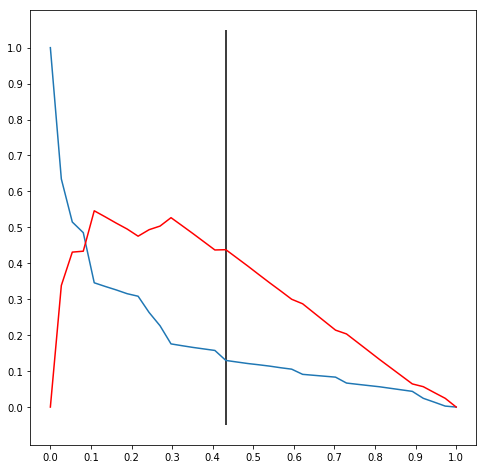

In [14]:
kneedle.plot_knee_normalized()

In [15]:
# Get the final clustering with best number of clusters
best_n = kneedle.knee
clustering = AgglomerativeClustering(n_clusters=best_n).fit(X)

### how do we decide the minor clusters

In [16]:
c_sizes = list()
for i in range(best_n):
    c_size = np.sum(clustering.labels_==i)
    c_sizes.append(c_size)

In [17]:
c_percents = c_sizes/np.sum(c_sizes)
c_percents

array([0.00186846, 0.00149477, 0.04671151, 0.0799701 , 0.00224215,
       0.00112108, 0.00149477, 0.00112108, 0.20702541, 0.00149477,
       0.06390135, 0.21562033, 0.06726457, 0.07660688, 0.00149477,
       0.19095665, 0.00149477, 0.03811659])

## 3. Autoencoder model

In [18]:
import math
clusters = np.unique(clustering.labels_)
models = list()
for i in np.nditer(clusters):
    if (c_percents[i])>0.01:
        data = X[clustering.labels_==i]

        # configure problem
        n_inputs = window_size
        n_units_1 = math.floor(n_inputs/2)
        n_units_2 = math.floor(n_units_1/2)
        # define model
        # define model
        autoencoder_model = Sequential()
        autoencoder_model.add(Dense(n_units_1, input_shape=(n_inputs,)))
        autoencoder_model.add(Dense(n_units_2, input_shape=(n_units_1,)))
        autoencoder_model.add(Dense(n_units_1, input_shape=(n_units_2,)))
        autoencoder_model.add(Dense(n_inputs))
        autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')

        # fit model
        autoencoder_model.fit(data, data, epochs=200, shuffle=True, verbose=1)

        # store the model
        model = Sequential()
        model.add(Dense(n_units_1, input_shape=(n_inputs,)))
        model.add(Dense(n_units_2, input_shape=(n_units_1,)))
        model.add(Dense(n_units_1, input_shape=(n_units_2,)))
        model.add(Dense(n_inputs))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.set_weights(autoencoder_model.get_weights())

        models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
125/125 [==============================] - 0s 2ms/step - loss: 1669.4793
Epoch 2/200
125/125 [==============================] - 0s 55us/step - loss: 927.3870
Epoch 3/200
125/125 [==============================] - 0s 66us/step - loss: 747.2660
Epoch 4/200
125/125 [==============================] - 0s 56us/step - loss: 633.8515
Epoch 5/200
125/125 [==============================] - 0s 111us/step - loss: 487.3665
Epoch 6/200
125/125 [==============================] - 0s 245us/step - loss: 367.4181
Epoch 7/200
125/125 [==============================] - 0s 94us/step - loss: 274.3251
Epoch 8/200
125/125 [==============================] - 0s 85us/step - loss: 188.9472
Epoch 9/200
125/125 [==============================] - 0s 78us/step - loss: 116.7471
Epoch 10/200
125/125 [==============================] - 0s 124us/step - loss: 67.1303
Epoch 11/200
125/125 [=====

## 3. Anomaly Scoring

In [19]:
scores = list()
for i in range(len(X)):
    min_score = float('inf')
    for model in models:
        yhat = model.predict(X[i].reshape(1, n_inputs))
        y_est = yhat[0]#*(sequences.max()-sequences.min())+sequences.min()
        y_gt = X[i]#*(sequences.max()-sequences.min())+sequences.min()
        
        # here we use simple square errors
        # But other type of errors or different normalization schemes 
        # can be applied. For example, the squared errors can be normalized 
        # by the signal itself. np.sum(np.square((y_est-y_gt)/y_gt))
        score = np.sum(np.square((y_est-y_gt)))
        if (score<min_score):
            min_score=score
    
    scores.append(min_score)


### 3.1 Find top 5% anomaly

In [20]:
sorted_scores = -np.sort(-np.array(scores))
sorted_scores_idx = np.argsort(-np.array(scores))

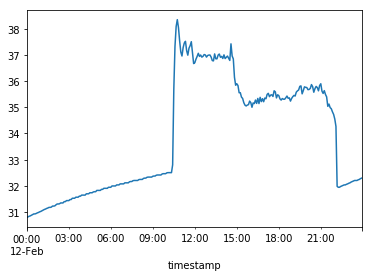

In [21]:
series1['2019-02-12'].plot()

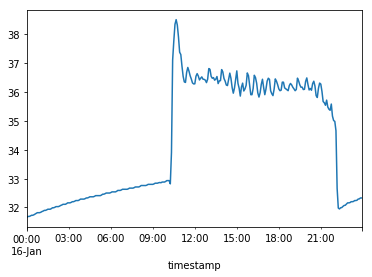

In [22]:
series1['2019-01-16'].plot()

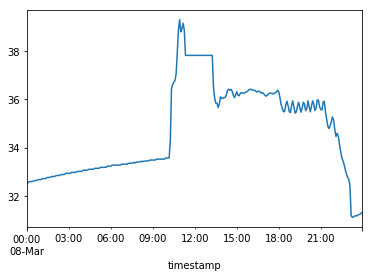

In [23]:
series1['2019-03-08'].plot()

In [26]:
data = series1.loc[[seq_timestamps[i] for i in sorted_scores_idx]]
index = [seq_timestamps[i] for i in sorted_scores_idx]
anomaly = pd.DataFrame({'value': data, 'scores': sorted_scores},index=index)

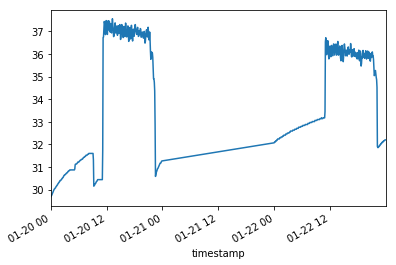

In [27]:
series1['2019-01-20':'2019-01-22'].plot()

### Visualize the anomaly

In [28]:
import math
anomaly_percent = 0.05
anomaly_range = range(math.floor(anomaly.shape[0]*anomaly_percent))

[]

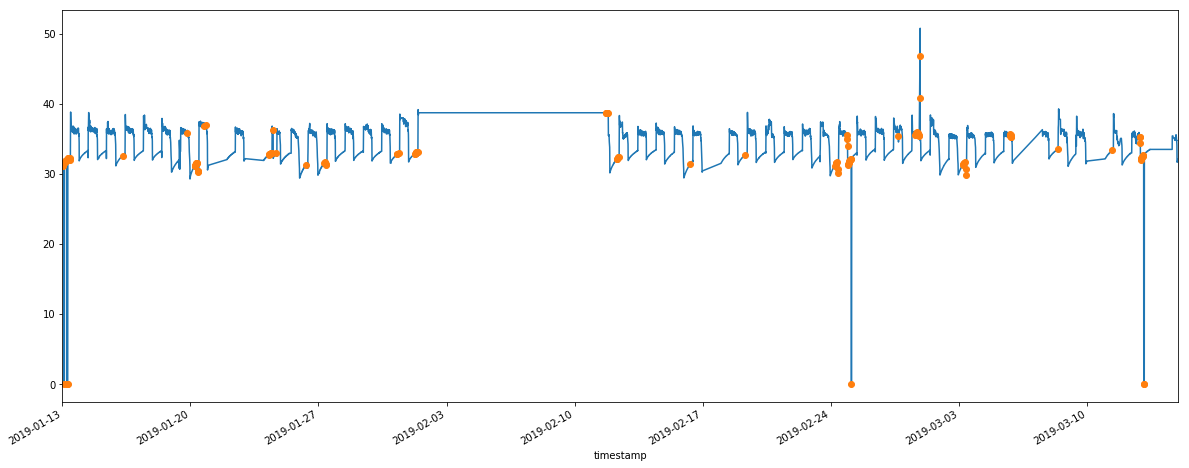

In [29]:
import matplotlib.pyplot as plt
series1.plot(figsize=(20, 8))
anomaly.iloc[anomaly_range]['value'].plot(style='o')
plt.plot()

### Deep dive to a specific anomaly

[]

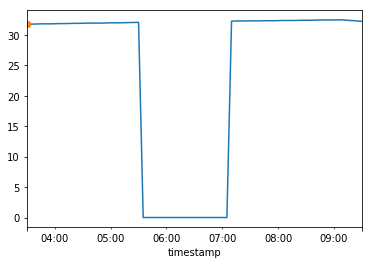

In [56]:
from datetime import timedelta
window_length = timedelta(minutes=window_size*5)
anomaly_idx = 7
series1[anomaly.index[anomaly_idx]:anomaly.index[anomaly_idx]+window_length].plot()
anomaly.iloc[[anomaly_idx, anomaly_idx]]['value'].plot(style='o')
plt.plot()